## Introduction/Business Problem
### A description of the problem and a discussion of the background. (15 marks)

Problem: When restaurants are being opened, it is good to assess the competition in the area. Opening restaurants in a densely populated area of resturants can result might not result in much revenue. Thus when planning to open a new restaurant, it will be good to understand where it can be opened, in terms of restaurants based in the location and the population of the area. It will help the stake holders to understand if a new restaurant can be opened.

## Data 
### A description of the data and how it will be used to solve the problem. (15 marks)

The following areas are required to investigate the problem space:
1) Number of restaurant in the neighbourhood
1) Distance between the Restuarants



number of existing restaurants in the neighborhood (any type of restaurant)
number of and distance to Italian restaurants in the neighborhood, if any
distance of neighborhood from city center

Following data sources will be needed to extract/generate the required information:

Population details of each neighbourhood
number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API

In [4]:
import pandas as pd
import requests # library to handle requests
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut
import yaml
import time

In [5]:
config_file = 'C:/Users/Muthumani/Desktop/Coursera_Capstone/config.yaml'

with open(config_file) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    config_file = yaml.load(file)


## From segmenting assignment

In [6]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml')


url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml')

# Get all the details
tabulka = soup.find("table", {"class" : "wikitable sortable"})
tabulka.prettify()
gdp_table_data = tabulka.tbody.find_all("tr") 

table_data = []
data = {}
for item in gdp_table_data:
    # Get all the headings of Lists
    headings = []
    for td in gdp_table_data[0].find_all("th"):
        # Extract the headings and remove whitespaces
        headings.append(td.text.replace('\n', ' ').strip())

    # Get all the rows of table
    t_row = {}
    row_data=[]
    for tr in item.find_all("td"):
        for data in tr:
            text = data.replace('\n', ' ').strip()
            row_data.append(text)
    # Append to table    
    table_data.append(row_data)
    
# Convert to table and drop the first row
table= pd.DataFrame(table_data,columns=headings)
table = table.iloc[1:]
table.head(5)
# remove the records that do not have borough
table = table[table['Borough']!='Not assigned']
# Obtain the unique boroughs and append the country name: Canada
boroughs = table.Borough.unique()
boroughs = [(borough+' ,Canada') for borough in boroughs]
boroughs

['North York ,Canada',
 'Downtown Toronto ,Canada',
 'Etobicoke ,Canada',
 'Scarborough ,Canada',
 'East York ,Canada',
 'York ,Canada',
 'East Toronto ,Canada',
 'West Toronto ,Canada',
 'Central Toronto ,Canada',
 'Mississauga ,Canada']

### Foursquare API data

In [94]:
# Obtain the lat and long of address
def lat_long(address, recursion):
    try:
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        return location.latitude,location.longitude
    except GeocoderTimedOut:
        if(recursion<5):
            print("sleep for 5 mins")
            time.sleep(5)
            lat_long(address, recursion+1)
        else:
            return 0,0
        

In [91]:
# Read in the config file details
def obtain_venues(address, radius, LIMIT):
    try:
        CLIENT_ID = config_file['client']['ID'] # your Foursquare ID
        CLIENT_SECRET = config_file['client']['secret'] # your Foursquare Secret
        VERSION = '20190604'
        #Obtain the lat and long for each address
        latitude, longitude = lat_long(address, 0)
        search_query = ''

        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET,latitude, longitude , VERSION, search_query, radius, LIMIT)
        #Obtain the results from the request
        results = requests.get(url).json()
        #Obtain the venue details and assign
        venues = results['response']['venues']
        # tranform into a dataframe
        venues_df = json_normalize(venues)
        #Obtain the category of the venue
        venue_category = [venue['categories'][0]['name'] if len(venue['categories']) >0 else '' for venue in venues ]
        # convert list to column
        venues_df = venues_df.assign(category_name=venue_category)
    
    except(TypeError, AttributeError):
        venues_df = pd.DataFrame()
    
    
    return venues_df

In [9]:
venues_total = pd.DataFrame()
for borough in boroughs:
    results = obtain_venues(borough, 1000, 400) 
    venues_total =venues_total.append(results, ignore_index=True)


For  North York ,Canada  lat:  43.7543263 longitude:  -79.44911696639593
For  Downtown Toronto ,Canada  lat:  43.6563221 longitude:  -79.3809161
For  Etobicoke ,Canada  lat:  43.671459150000004 longitude:  -79.55249206611668
For  Scarborough ,Canada  lat:  43.773077 longitude:  -79.257774
For  East York ,Canada  lat:  43.699971000000005 longitude:  -79.33251996261595
For  York ,Canada  lat:  46.0885262 longitude:  -66.9308031
For  East Toronto ,Canada  lat:  43.72178945 longitude:  -79.37402706301704
For  West Toronto ,Canada  lat:  43.6534817 longitude:  -79.3839347
For  Central Toronto ,Canada  lat:  43.6534817 longitude:  -79.3839347
For  Mississauga ,Canada  lat:  43.590338 longitude:  -79.645729


### Methodology

In [11]:
#Example of data
print(venues_total.shape[0])
venues_total.head(5)

966


,categories,category_name,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d132941735', 'name': 'C...",Church,False,4e74b54e45ddd4323f6407ac,788 Sheppard Avenue West,CA,Toronto,Canada,NaN,62,"[788 Sheppard Avenue West, Toronto ON M3H 2T1,...","[{'label': 'display', 'lat': 43.75380469452393...",43.753805,-79.448834,NaN,M3H 2T1,ON,Filipino Canadian SDA Church,v-1589761397,NaN
1,"[{'id': '4bf58dd8d48988d12b951735', 'name': 'B...",Bus Line,False,4b7084f6f964a5207c1f2de3,Sheppard Ave. W.,CA,Toronto,Canada,btwn Sheppard-Yonge Station & Weston Rd.,563,[Sheppard Ave. W. (btwn Sheppard-Yonge Station...,"[{'label': 'display', 'lat': 43.75197019643381...",43.751970,-79.455324,NaN,NaN,ON,TTC Bus 84 Sheppard West,v-1589761397,NaN
2,"[{'id': '5370f356bcbc57f1066c94c2', 'name': 'B...",Beer Store,False,5d421de99971ba000898a48a,81 Billy Bishop Way,CA,North York,Canada,NaN,2468,"[81 Billy Bishop Way, North York ON M3K 0C2, C...","[{'label': 'display', 'lat': 43.7322239, 'lng'...",43.732224,-79.451523,NaN,M3K 0C2,ON,The Beer Store,v-1589761397,551064908
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",Pizza Place,False,50f9bbcc5d24acebc25936af,820 Sheppard Ave W,CA,Toronto,Canada,NaN,197,"[820 Sheppard Ave W, Toronto ON M3H 2T1, Canada]","[{'label': 'display', 'lat': 43.75312660212406...",43.753127,-79.450926,NaN,M3H 2T1,ON,Domino's Pizza,v-1589761397,NaN
4,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",Residential Building (Apartment / Condo),False,4c541ae1fd2ea59360818829,778 Sheppard Ave. West,CA,Toronto,Canada,Goddard,113,"[778 Sheppard Ave. West (Goddard), Toronto ON,...","[{'label': 'display', 'lat': 43.75338085, 'lng...",43.753381,-79.448593,NaN,NaN,ON,778 Sheppard Ave. West,v-1589761397,NaN


### Understand the unique types of categories

In [12]:
venues_total['category_name'].unique()
venues_total['category_type'] = venues_total['category_name'].str.split(' ',expand = True)[1]
venues_total.loc[venues_total['category_name'].str.contains('Restaurant'),'category_type'] = 'Restaurant'
venues_total['category_type'].unique()

array([None, 'Line', 'Store', 'Place', 'Building', 'Restaurant', 'Cream',
       'Office', 'Joint', 'Service', 'Shop', 'Chicken', '/', 'Station',
       '&', 'Salon', 'Space', 'School', 'Center', 'Studio',
       'Entertainment', 'Gallery', 'or', 'Bar', 'Goods', 'Theater',
       'Mall', 'Rail', 'Dog', 'Provider', 'Arts', 'Yogurt', 'Food', 'Gym',
       'Exchange', 'Truck', 'Auditorium', 'Plaza', 'Room', 'Travel',
       'Startup', 'Rink', 'Field', 'Stop', 'Classroom', 'Club', 'Base',
       'Spot', 'Court', 'Lookout', 'Repair', 'Agency', 'Tea', 'Run',
       'College', 'Venue', 'Target', 'Area', 'Phone', 'Booth', 'Site',
       'Art', 'Garden', 'Garage', 'Lounge', 'Great', 'Lab', 'Ward',
       'Academic', 'Quad', 'Library', 'Development', 'Estate',
       'Residence', 'Cafeteria', 'Hall', 'Market', 'Rental', 'Event',
       'Nightlife', 'Therapist'], dtype=object)

In [123]:
#Drop the values which have null
venues_city = venues_total[~venues_total['location.city'].isnull()]
venues_city.head(5)

,categories,category_name,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,...,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id,category_type
0,"[{'id': '4bf58dd8d48988d132941735', 'name': 'C...",Church,False,4e74b54e45ddd4323f6407ac,788 Sheppard Avenue West,CA,Toronto,Canada,NaN,62,...,"[{'label': 'display', 'lat': 43.75380469452393...",43.753805,-79.448834,NaN,M3H 2T1,ON,Filipino Canadian SDA Church,v-1589761397,NaN,None
1,"[{'id': '4bf58dd8d48988d12b951735', 'name': 'B...",Bus Line,False,4b7084f6f964a5207c1f2de3,Sheppard Ave. W.,CA,Toronto,Canada,btwn Sheppard-Yonge Station & Weston Rd.,563,...,"[{'label': 'display', 'lat': 43.75197019643381...",43.751970,-79.455324,NaN,NaN,ON,TTC Bus 84 Sheppard West,v-1589761397,NaN,Line
2,"[{'id': '5370f356bcbc57f1066c94c2', 'name': 'B...",Beer Store,False,5d421de99971ba000898a48a,81 Billy Bishop Way,CA,North York,Canada,NaN,2468,...,"[{'label': 'display', 'lat': 43.7322239, 'lng'...",43.732224,-79.451523,NaN,M3K 0C2,ON,The Beer Store,v-1589761397,551064908,Store
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",Pizza Place,False,50f9bbcc5d24acebc25936af,820 Sheppard Ave W,CA,Toronto,Canada,NaN,197,...,"[{'label': 'display', 'lat': 43.75312660212406...",43.753127,-79.450926,NaN,M3H 2T1,ON,Domino's Pizza,v-1589761397,NaN,Place
4,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",Residential Building (Apartment / Condo),False,4c541ae1fd2ea59360818829,778 Sheppard Ave. West,CA,Toronto,Canada,Goddard,113,...,"[{'label': 'display', 'lat': 43.75338085, 'lng...",43.753381,-79.448593,NaN,NaN,ON,778 Sheppard Ave. West,v-1589761397,NaN,Building


#### View the distribution of venues in Canada
As can be seen from below, Totoronto, Mississauga and Scarbough seem to have the most venues

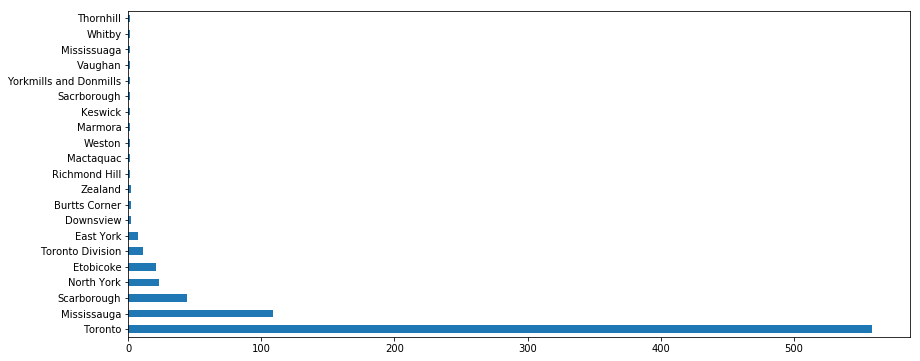

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,6)
venues_city['location.city'].value_counts().plot.barh()
plt.show()

### Assign unique colour to category

In [17]:
import random
#Generate random colour
def gen_col():
    r = lambda: random.randint(0,255)
    col = '#%02X%02X%02X' % (r(),r(),r())
    return col

# Assign random colour to each category
latitude, longitude = lat_long('Toronto Canada', 0)
categories = venues_total['category_type'].unique()
colours = [ gen_col() for venue in categories]
category_colour = pd.DataFrame({'category':categories,'colour':colours})
# Merge with Venue city to obtain unique colours
venues_city = pd.merge(venues_city,category_colour,left_on = 'category_type', right_on='category')

In [124]:
# Filters the restaurant types
venues_res = venues_city[venues_city['category_name'].str.contains('Restaurant')]
# Drop the values which are null
venues_res = venues_res[~venues_res['location.address'].isnull()]
venues_res.head(5)

,categories,category_name,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,...,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id,category_type
10,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",Middle Eastern Restaurant,False,4c9e7135542b224b753ff49f,564 wilson heights blvd.,CA,Toronto,Canada,NaN,696,...,"[{'label': 'display', 'lat': 43.752514, 'lng':...",43.752514,-79.457409,NaN,NaN,ON,The Pita Spot,v-1589761397,NaN,Restaurant
12,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",Mediterranean Restaurant,False,5a888f7647f8767d37b92f00,832 Sheppard West,CA,North York,Canada,NE corner of Sheppard & Wilmington,246,...,"[{'label': 'display', 'lat': 43.75312297840480...",43.753123,-79.451690,Bathurst Manor,M3H 2T1,ON,Grill Gate,v-1589761397,NaN,Restaurant
35,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",American Restaurant,False,4b4a37b6f964a520387f26e3,531 Wilson Heights Blvd,CA,Toronto,Canada,Bathurst St,635,...,"[{'label': 'display', 'lat': 43.75105767114834...",43.751058,-79.455591,NaN,NaN,ON,Times Square Diner,v-1589761397,NaN,Restaurant
42,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",Sushi Restaurant,False,4c9fd84e542b224b3f2701a0,638 Sheppard Ave W,CA,Toronto,Canada,NaN,667,...,"[{'label': 'display', 'lat': 43.75538218503698...",43.755382,-79.440945,NaN,M3H 2S1,ON,Wakame Sushi,v-1589761397,NaN,Restaurant
45,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",Restaurant,False,4b65c410f964a52050fe2ae3,634 Sheppard Avenue W.,CA,North York,Canada,NaN,688,...,"[{'label': 'display', 'lat': 43.75539484400371...",43.755395,-79.440686,NaN,NaN,ON,Bagel Plus,v-1589761397,NaN,Restaurant


### Get the type of venues which are nearest to restaurant

In [93]:
nearest_locations = pd.DataFrame(columns=['location','nearest_locations'])
for veneue_res in venues_res['location.address']:
    try:
        #Obtain other top ten venues which are near to restaurant with radius of 5
        results = obtain_venues(veneue_res, 5, 10)
        nearest_loc = results['category_name'].values.tolist()
        # Add to dataframe
    except (AttributeError, ValueError, TypeError, KeyError):
        nearest_loc = []
    finally:
        nearest_locations = nearest_locations.append(pd.DataFrame({"location":veneue_res, 
                    "nearest_locations": [nearest_loc] }), ignore_index = True)


In [125]:
# Find the nearest locations for each address
venues_res = pd.merge(venues_res,nearest_locations,left_on = 'location.address', right_on='location')
venues_res = venues_res.drop_duplicates(subset="location.address")
venues_res.head(5)

,categories,category_name,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,...,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id,category_type,location,nearest_locations
0,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",Middle Eastern Restaurant,False,4c9e7135542b224b753ff49f,564 wilson heights blvd.,CA,Toronto,Canada,NaN,696,...,-79.457409,NaN,NaN,ON,The Pita Spot,v-1589761397,NaN,Restaurant,564 wilson heights blvd.,"[Gas Station, Bus Line, Convenience Store, Fre..."
1,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",Mediterranean Restaurant,False,5a888f7647f8767d37b92f00,832 Sheppard West,CA,North York,Canada,NE corner of Sheppard & Wilmington,246,...,-79.451690,Bathurst Manor,M3H 2T1,ON,Grill Gate,v-1589761397,NaN,Restaurant,832 Sheppard West,"[Park, , Rest Area, American Restaurant, Fast ..."
2,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",American Restaurant,False,4b4a37b6f964a520387f26e3,531 Wilson Heights Blvd,CA,Toronto,Canada,Bathurst St,635,...,-79.455591,NaN,NaN,ON,Times Square Diner,v-1589761397,NaN,Restaurant,531 Wilson Heights Blvd,"[Office, American Restaurant, Coffee Shop, Piz..."
3,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",Sushi Restaurant,False,4c9fd84e542b224b3f2701a0,638 Sheppard Ave W,CA,Toronto,Canada,NaN,667,...,-79.440945,NaN,M3H 2S1,ON,Wakame Sushi,v-1589761397,NaN,Restaurant,638 Sheppard Ave W,"[Metro Station, Gas Station, Coffee Shop, Furn..."
4,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",Restaurant,False,4b65c410f964a52050fe2ae3,634 Sheppard Avenue W.,CA,North York,Canada,NaN,688,...,-79.440686,NaN,NaN,ON,Bagel Plus,v-1589761397,NaN,Restaurant,634 Sheppard Avenue W.,"[Metro Station, Gas Station, Coffee Shop, Furn..."


In [104]:
venues_res['nearest_locations'] = venues_res['nearest_locations'].str.join(',')

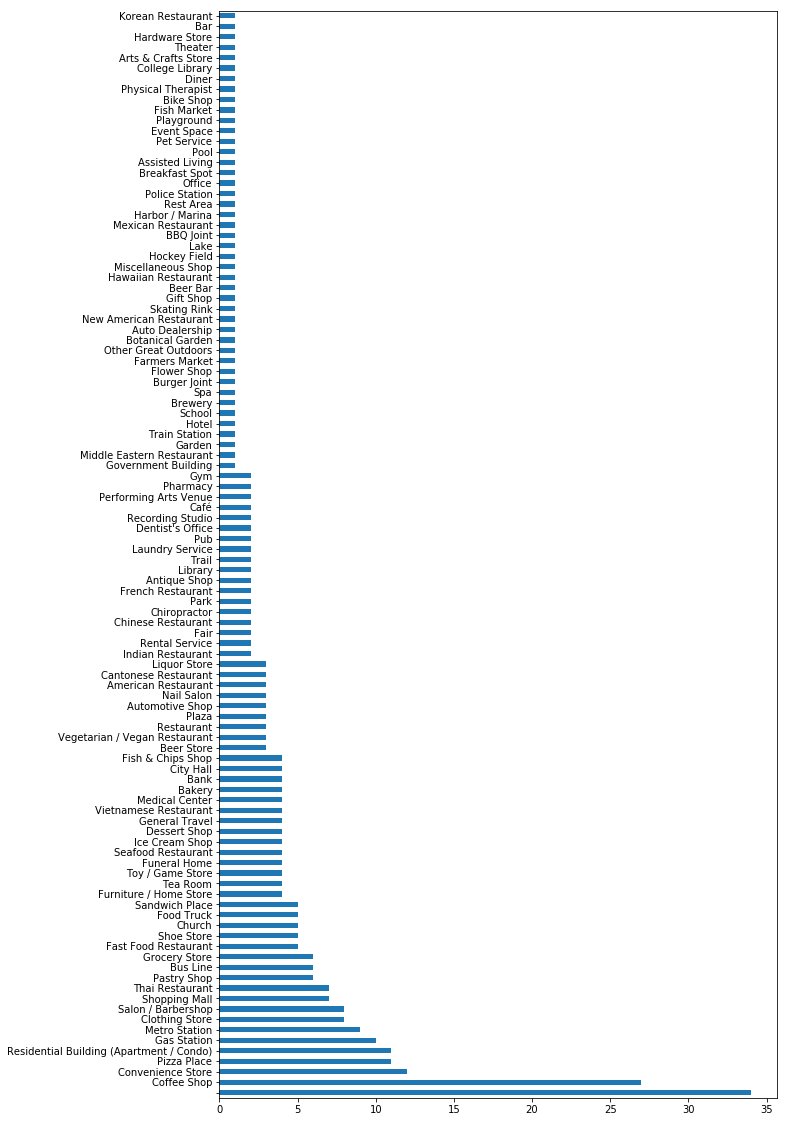

In [122]:
from pandas import Series 

venues_res[['location','category_type','nearest_locations']]

locations = pd.concat([Series(row['location'], row['nearest_locations'].split(','))              
                    for _, row in venues_res.iterrows()]).reset_index()

plt.rcParams["figure.figsize"] = (10,20)
locations['index'].value_counts().plot.barh()
plt.show()


In [3]:
import folium

#### Analyse the clusters of venues 

In [256]:
# create map of Canada using latitude and longitude values
map_canada = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label, col in zip(venues_city['location.lat'], venues_city['location.lng'], venues_city['category_name'], venues_city['colour']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='grey',
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  
    
map_canada

#### Analyse the restaurants and how they are clustered

In [257]:
# create map of Canada using latitude and longitude values
map_canada = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label, col in zip(venues_res['location.lat'], venues_res['location.lng'], venues_res['category_name'], venues_res['colour']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='grey',
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  
    
map_canada

### Results section and Discussion
- As can be seen from the maps, restaurants tend to cluster together with other restaurants
- Most of the restaurants seem to be located near Gas station,coffee shops and other restaurants
- The clusters seem to be more near the city central rather than the outliers
- The number of restaurants seem to be higher near shopping malls

### Conclusion
- When opening a new restaurant , it is recommended to open near locations such as shopping malls, Gas stations
- As discussed in the discussion section, restaurants seem to be higher in population near city centre. So new restaurant owners can check the city centre first before considering other options